In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [4]:
from itertools import zip_longest

In [5]:
from freq_domain import plotspec
from utilities import power

from transmitter import *
from receiver import *
from impairments import *

## Section 9.1

### Parameters

In [6]:
msg = '01234 I wish I were an Oscar Meyer wiener 56789'
fc = 20 # Carrier frequency
M = 100 # oversampling factor
taps = 50

### Transmitter design

[-3, 3, -3, -3, -3]

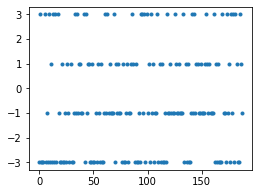

In [7]:
# Convert to PAM symbols
symbols = letters2pam(msg)
plt.plot(symbols, '.');
symbols[:5]

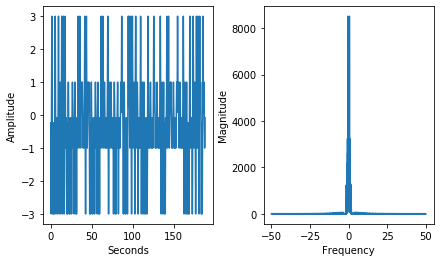

In [8]:
# Pulse shaping with a hamming pulse
analog_waveform = pulse_shaped(symbols, M)
Ts = 1/M
plotspec(analog_waveform, 1/M);

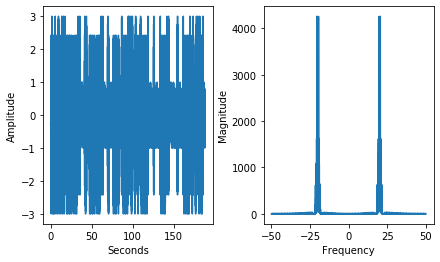

In [9]:
t, transmitted = modulate(analog_waveform, fc, 1/M)
plotspec(transmitted, 1/M);

### Impairments

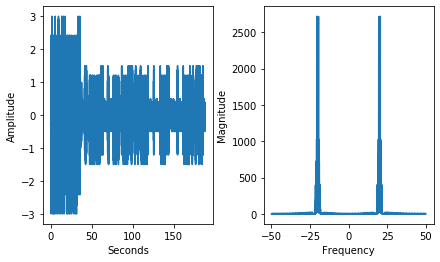

In [10]:
# Fading
faded = time_varying_fading_channel(transmitted)
plotspec(faded, Ts);

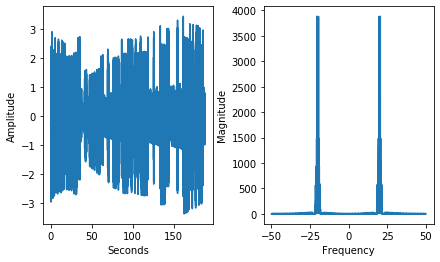

In [11]:
sig_after_agc, gains = agc(faded, power(transmitted))
plotspec(sig_after_agc, Ts);

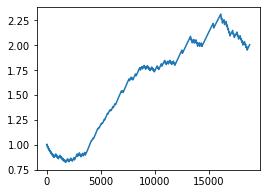

In [12]:
plt.plot(gains);

### Receiver design

In [13]:
received = sig_after_agc

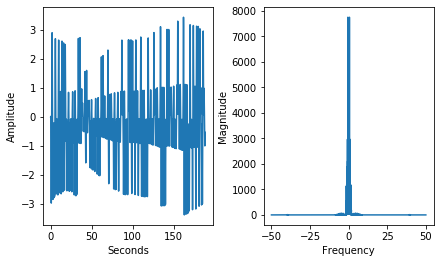

In [14]:
Ts = 1/M
baseband = demodulate(received, fc, Ts)
plotspec(baseband, Ts);

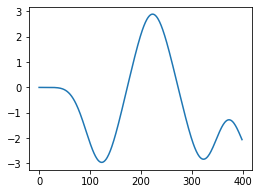

In [15]:
correlated = pulse_correlator(baseband, M)
# Filter delay of linear phase filter is (taps-1)/2 = 24.5, round to 25
# Peak for correlate(pulse, pulse) is at M - 1 = 99
# First best sampling time = 99 + 25 = 124
# After that, sample every M = 100 samples
plt.plot(correlated[:4*M]);
# The plot below corresponds to the first three symbols [-3, 3, -3]

In [16]:
# Check group delay of linear phase filter explicitly
# See explanations here:
# https://dsp.stackexchange.com/questions/18435/group-delay-of-the-fir-filter
# https://www.mathworks.com/help/signal/ug/compensate-for-the-delay-introduced-by-an-fir-filter.html
Fs = 1/Ts
band_edges = np.array([0, 0.1, 0.2, 1])*(Fs//2) # Cutoff at 0.2*Fs/2
damps = [1, 0]
b = signal.remez(taps, band_edges, damps, fs=Fs)
w, gd = signal.group_delay((b, 1))
gd.mean().round(2)

24.5

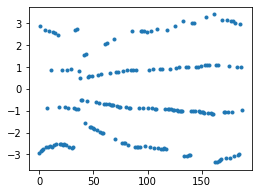

In [17]:
filter_delay = 25 # taps // 2
correlator_delay = M
sampling_start_idx = filter_delay + correlator_delay - 1
soft_decisions = correlated[sampling_start_idx::M]
plt.plot(soft_decisions, '.');

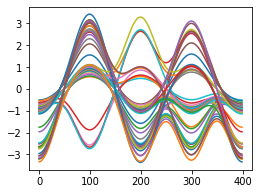

In [18]:
# Eye Diagram
num_groups = len(correlated[sampling_start_idx:])//(4*M)
#print(num_groups)
grouped_data = correlated[sampling_start_idx:sampling_start_idx+num_groups*4*M].reshape(-1, 4*M)
#print(grouped_data.shape)
plt.plot(grouped_data.T); 

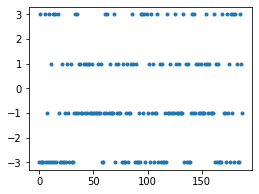

In [19]:
alphabet = np.array([-3, -1, 1, 3])
hard_decisions = quantalph(soft_decisions, alphabet)
plt.plot(hard_decisions, '.');

In [20]:
decoded_msg = pam2letters(hard_decisions)
num_errors = sum([dec != orig for dec, orig in zip_longest(decoded_msg, msg)])
print(f'Errors: {num_errors}')
decoded_msg

Errors: 5


'01234 I wifieY`were an Oscar Meyer wiener 56789'